# Example for using the tensorboard logger

The first part of this tutorial consists of the similar examples as in `numpy_visdom_logger_example.ipynb`.
The second part contains a pointer to advanced functionality as well as some example usages, in particular the use of tensorboard's hparam view.

*Make sure that tensorboard version 2.0 or later is installed in your environment.*


Start tensorboard by running
```tensorboard --logdir=runs```,
which will set up tensorboard such that it looks for event files in the `runs` directory.
Then navigate to `http://localhost:6006/` in your browser.



## Basic logging functions
### Plot a value


In [1]:
import numpy

In [2]:
from trixi.logger.tensorboard import TensorboardLogger
from time import sleep
import numpy as np

tb_logger = TensorboardLogger(target_dir='runs/my_log')

for i, x in enumerate(np.linspace(0, 10, 50)):
    y = np.sin(x)
    # Add one value to the plot. The x-axis values are determined by the counter and cannot be set directly.
    tb_logger.show_value(y, name="sin plot", counter=i)
    sleep(0.1)
    

In your browser, you should see an interactivate plot of the sine curve, for which a smoothing slider can be adjusted.
A value of 0 should yield the original data. 

### Plot image and text

In [3]:
from skimage.data import camera, checkerboard, chelsea, astronaut

images = [astronaut(), camera(), checkerboard(), chelsea()]

for i in range(50):
    img = images[i%len(images)] #use modulo to cycle images
    
    # color channel has to be in first dimension. tensorboard expects CHW if not specified otherwise in dataformat
    if len(img.shape) == 3:
        img = img.transpose((2,0,1)) #move color channel from last to first dimension
    elif len(img.shape) == 2:
        img = np.expand_dims(img, 0)
    
    tb_logger.show_image(img, name="img plot", counter=i)
    tb_logger.show_text("Iteration index: {}".format(i), name="text plot", counter=i)
    sleep(0.5)

You should see a new element in the "Images" tab within tensorboard. The slider above the image lets you scroll through steps. Unfortunately, for many steps, not all are saved. It is not clear yet if this is a trixi or tensorboard bug.
The text message for each step is displayed in the "Text" tab.

### Plot image grid

In [4]:
from skimage.data import camera, checkerboard, chelsea, astronaut, clock, coffee, coins, horse, moon, rocket
from skimage.transform import resize
from skimage.color import rgb2gray

images = [astronaut(), camera(), checkerboard(), chelsea(), clock(), coffee(), coins(), horse(), moon(), rocket()]
images_converted = []
for img in images:
    img = resize(img, (200, 200))   # make all images have same dimensions
    # img = img[:200,:200] 
    if len(img.shape) == 3:
        img = rgb2gray(img)    # if rgb convert into grayscale
    images_converted.append(img)
images_converted = np.array(images_converted)
s = images_converted.shape # (10, 200, 200)
images_converted = np.reshape(images_converted, (s[0], 1, s[1], s[2])) # images need to have channel dimension in the beginning. New shape: (10, 1, 200, 200)

#Show images
tb_logger.show_images(images_converted, name="img grid plot")

Images can be displayed in a grid with above function. The expected input shape is (number of images, number of channels, width, height)

## Advanced logging functions

Apart from the basic functionality above, tensorboard allows to log matplotlib figures, as well as data analysis tools and utilies such as:
* Histograms evolving with (time) step
* Visualization of feature space embeddings
* Visualization of model graph
* Plotting a PR curve
* Logging and comparing hyperparameters

For more information see the tutorial (https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html#writing-to-tensorboard), which transfers directly to the trixi logger, except that the methods are called `show_X` instead of `add_X`.

Here we only cover two use-cases: logging of a scatter plot and using the hparams-view of tensorboard with the trixi logger.

### Log scatter plot

(100, 2)


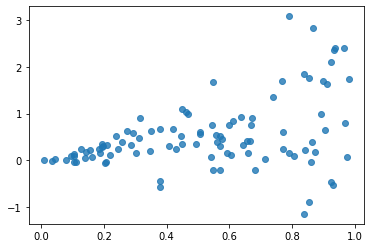

In [5]:
n_data = 100
x1 = np.random.rand(n_data)
y1 = x1 + np.random.randn(len(x1)) * x1
array = np.stack((x1, y1)).T
print(array.shape)
tb_logger.show_scatterplot(array, name="Correlations")

As you can see, this method saves a copy of the plot in the image tab of tensorboard and also returns the figure.

## hparam view
Using tensorboard, it is possible to log the hyperparameters used for an experiment and compare the performance of different hyperparameter configurations. Below we generate some dummy hparams and metrics and log them in tensorboard using the `show_hparams` method, which directly passes the arguments on to the tensorboard writer.

In [6]:
def get_all_combinations(value_dict):
    import itertools as it
    allNames = sorted(value_dict)
    combinations = it.product(*(value_dict[Name] for Name in allNames))
    return allNames, list(combinations)

hparam_values = {
    'learning_rate': [1e-3, 1e-2],
    'batch_size': [64, 128],
    'dropout': [True, False],
    'architecture': ['AlexNet', 'ResNet18']
}

hparam_keys, hparams_combinations = get_all_combinations(hparam_values)
for i, hparams in enumerate(hparams_combinations):
    hparam_dict = {k: hparams[i] for i, k in enumerate(hparam_keys)}
    metric_dict = {'hparam/accuracy': np.random.rand(),
                   'hparam/loss': i}
    tb_logger.show_hparams(hparam_dict, metric_dict)
    

In the hparams-tab in tensorboard, you can compare the performances for each configuration.

One way to incororate this functionality in a trixi experiment is to log the hparams in the `Experiment.end()` method.